In [2]:
!unzip /content/2009_2016.csv.zip

Archive:  /content/2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import pandas as pd
df = pd.read_csv('/content/jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [9]:
temperature =  df['T (degC)'].to_numpy()
len(temperature)

420451

In [10]:
raw_data = df.iloc[:,1:].to_numpy()

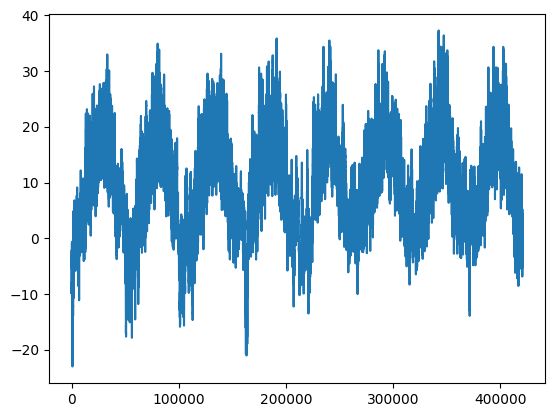

In [10]:
import matplotlib.pyplot as plt
plt.plot(temperature)
plt.show()

In [11]:
# 1 day : 144
df['Date Time'][:144]

0      01.01.2009 00:10:00
1      01.01.2009 00:20:00
2      01.01.2009 00:30:00
3      01.01.2009 00:40:00
4      01.01.2009 00:50:00
              ...         
139    01.01.2009 23:20:00
140    01.01.2009 23:30:00
141    01.01.2009 23:40:00
142    01.01.2009 23:50:00
143    02.01.2009 00:00:00
Name: Date Time, Length: 144, dtype: object

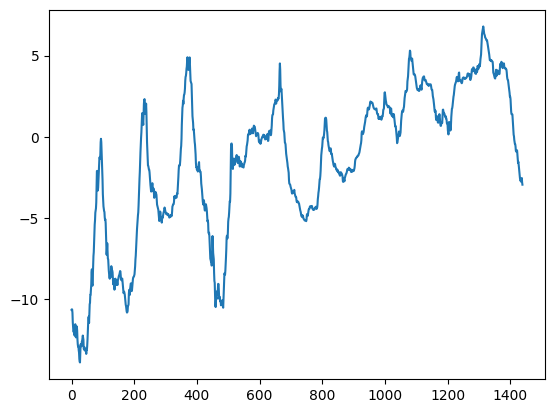

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(temperature[:1440])
plt.plot(temperature[1440:1440+1440])
plt.show()

데이터 준비
  - train : 0.5
  - val : 0.25
  - test

In [5]:
num_train_samples = int(0.5*len(raw_data))
num_val_samples = int(0.25*len(raw_data))
num_test_samples = len(raw_data) - num_train_samples-num_val_samples
num_train_samples,num_val_samples,num_test_samples

(210225, 105112, 105114)

데이터 정규화
  - 평균 : 각값에서 평균을 빼고
  - 표준편차 : 그 값에다가 표준편차로 나눈다

In [13]:
m = raw_data[:num_train_samples].mean(axis=0)
raw_data -= m
s = raw_data[:num_train_samples].std(axis=0)
raw_data /= s

In [7]:
import tensorflow as tf
import numpy as np

In [15]:
int_sequence = np.arange(10)
print(int_sequence)
dummy_dataset =  tf.keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length=3,
    batch_size=2
)
int_sequence[:-3],int_sequence[3:]

[0 1 2 3 4 5 6 7 8 9]


(array([0, 1, 2, 3, 4, 5, 6]), array([3, 4, 5, 6, 7, 8, 9]))

In [16]:
for inputs, targets in dummy_dataset:
  print(inputs)
  print(targets)


tf.Tensor(
[[0 1 2]
 [1 2 3]], shape=(2, 3), dtype=int64)
tf.Tensor([3 4], shape=(2,), dtype=int64)
tf.Tensor(
[[2 3 4]
 [3 4 5]], shape=(2, 3), dtype=int64)
tf.Tensor([5 6], shape=(2,), dtype=int64)
tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int64)
tf.Tensor([7], shape=(1,), dtype=int64)


훈련용,검증용,테스트용 데이터 생성

In [11]:
# 하루를 6시간 단위로 나눠서 예측
# 시퀀스길이 * 6 =
# delay = (시퀀스길이 +24)*sampling_rate

sampling_rate = 6
sequence_length = 120
delay = sampling_rate*(sequence_length+24-1)
batch_size = 256
train_dataset =  tf.keras.utils.timeseries_dataset_from_array(
    data = raw_data[:-delay],
    targets= temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length = sequence_length,
    batch_size=batch_size ,
    shuffle=True,
    start_index = 0,
    end_index=num_train_samples
)

val_dataset =  tf.keras.utils.timeseries_dataset_from_array(
    data = raw_data[:-delay],
    targets = temperature[delay:],
    sequence_length = sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size ,
    shuffle=True,
    start_index = num_train_samples,
    end_index=num_train_samples+num_val_samples
)
test_dataset =  tf.keras.utils.timeseries_dataset_from_array(
    data = raw_data[:-delay],
    targets = temperature[delay:],
    sequence_length = sequence_length,
    sampling_rate=sampling_rate,
    shuffle=True,
    batch_size=batch_size ,
    start_index = num_train_samples+num_val_samples,
)

MAE 계산

In [ ]:
for data,target in train_dataset:
  print(data.shape)
  print(target.shape)
  break

(256, 120, 14)
(256,)


In [ ]:
inputs = tf.keras.Input(shape=(sequence_length,raw_data.shape[-1]))  # 120,14
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(16,activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs,outputs)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model_temp.h5',save_best_only=True)
]
model.compile(loss = 'mse', metrics=['mae'])
hist = model.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=callbacks)
print(f'test mae: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
821/821 [==============================] - 60s 72ms/step - loss: 7.1404 - mae: 1.9139 - val_loss: 3.9224 - val_mae: 1.3689
Epoch 2/10
821/821 [==============================] - 47s 58ms/step - loss: 3.6245 - mae: 1.3198 - val_loss: 2.9676 - val_mae: 1.1590
Epoch 3/10
821/821 [==============================] - 48s 58ms/step - loss: 2.5943 - mae: 1.1561 - val_loss: 1.4502 - val_mae: 0.8394
Epoch 4/10
821/821 [==============================] - 53s 65ms/step - loss: 2.0306 - mae: 1.0200 - val_loss: 1.0076 - val_mae: 0.7633
Epoch 5/10
821/821 [==============================] - 48s 58ms/step - loss: 1.6722 - mae: 0.9309 - val_loss: 1.5012 - val_mae: 0.8817
Epoch 6/10
821/821 [==============================] - 56s 69ms/step - loss: 1.4102 - mae: 0.8698 - val_loss: 1.0528 - val_mae: 0.7587
Epoch 7/10
821/821 [==============================] - 54s 66ms/step - loss: 1.2843 - mae: 0.8277 - val_loss: 1.1011 - val_mae: 0.7135
Epoch 8/10
821/821 [==============================] - 47s 58ms

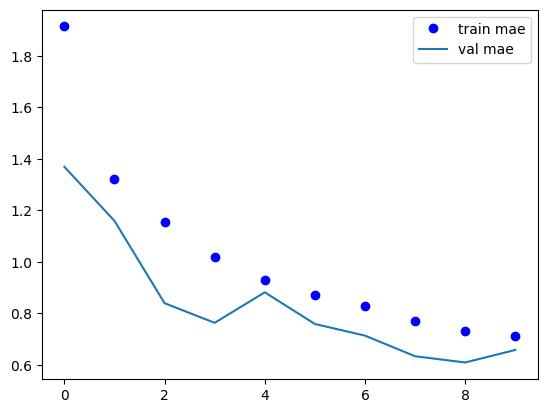

In [ ]:
plt.plot(hist.history['mae'],'bo',label='train mae')
plt.plot(hist.history['val_mae'],label='val mae')
plt.legend()
plt.show()

1D 합성곱 모델 적용

In [ ]:
inputs = tf.keras.Input(shape=(sequence_length,raw_data.shape[-1]))  # 120,14
x = tf.keras.layers.Conv1D(8,24,activation='relu')(inputs)
x = tf.keras.layers.MaxPool1D(2)(x)
x = tf.keras.layers.Conv1D(8,12,activation='relu')(x)
x = tf.keras.layers.MaxPool1D(2)(x)
x = tf.keras.layers.Conv1D(8,6,activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs,outputs)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model_conv1d.h5',save_best_only=True)
]
model.compile(loss = 'mse', metrics=['mae'])
hist = model.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=callbacks)
print(f'test mae: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 [==============================] - 58s 69ms/step - loss: 23.5741 - mae: 3.7775 - val_loss: 16.7055 - val_mae: 3.2582
Epoch 2/10
819/819 [==============================] - 58s 70ms/step - loss: 15.6138 - mae: 3.1302 - val_loss: 14.9127 - val_mae: 3.0358
Epoch 3/10
819/819 [==============================] - 56s 68ms/step - loss: 14.1871 - mae: 2.9912 - val_loss: 16.7474 - val_mae: 3.2215
Epoch 4/10
819/819 [==============================] - 64s 78ms/step - loss: 13.1524 - mae: 2.8724 - val_loss: 15.1156 - val_mae: 3.0445
Epoch 5/10
819/819 [==============================] - 58s 70ms/step - loss: 12.3800 - mae: 2.7826 - val_loss: 15.1186 - val_mae: 3.0331
Epoch 6/10
819/819 [==============================] - 61s 74ms/step - loss: 11.8341 - mae: 2.7199 - val_loss: 16.0577 - val_mae: 3.1406
Epoch 7/10
819/819 [==============================] - 70s 85ms/step - loss: 11.3693 - mae: 2.6639 - val_loss: 15.6831 - val_mae: 3.0942
Epoch 8/10
819/819 [============================

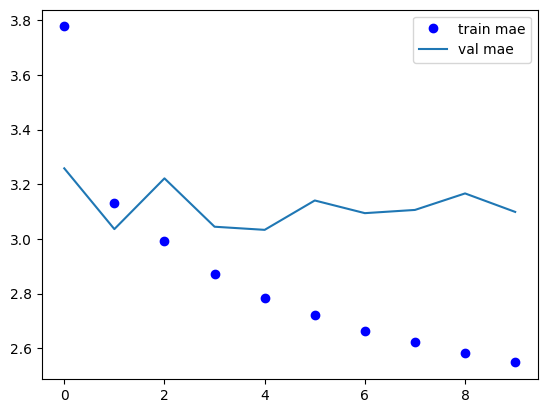

In [ ]:
plt.plot(hist.history['mae'],'bo',label='train mae')
plt.plot(hist.history['val_mae'],label='val mae')
plt.legend()
plt.show()

순환신경망  LSTM


In [ ]:
inputs = tf.keras.Input(shape=(sequence_length,raw_data.shape[-1]))  # 120,14
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs,outputs)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model_lstm.h5',save_best_only=True)
]
model.compile(loss = 'mse', metrics=['mae'])
hist = model.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=callbacks)
print(f'test mae: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 [==============================] - 74s 87ms/step - loss: 39.3861 - mae: 4.5522 - val_loss: 11.8109 - val_mae: 2.6260
Epoch 2/10
819/819 [==============================] - 70s 85ms/step - loss: 10.9450 - mae: 2.5686 - val_loss: 9.9102 - val_mae: 2.4420
Epoch 3/10
819/819 [==============================] - 71s 86ms/step - loss: 9.7796 - mae: 2.4344 - val_loss: 9.8585 - val_mae: 2.4316
Epoch 4/10
819/819 [==============================] - 70s 85ms/step - loss: 9.1783 - mae: 2.3542 - val_loss: 9.5109 - val_mae: 2.3851
Epoch 5/10
819/819 [==============================] - 71s 86ms/step - loss: 8.7478 - mae: 2.2991 - val_loss: 9.7034 - val_mae: 2.4026
Epoch 6/10
819/819 [==============================] - 70s 85ms/step - loss: 8.4635 - mae: 2.2624 - val_loss: 9.7894 - val_mae: 2.4206
Epoch 7/10
819/819 [==============================] - 72s 87ms/step - loss: 8.2916 - mae: 2.2400 - val_loss: 10.0271 - val_mae: 2.4558
Epoch 8/10
819/819 [==============================] - 69s 

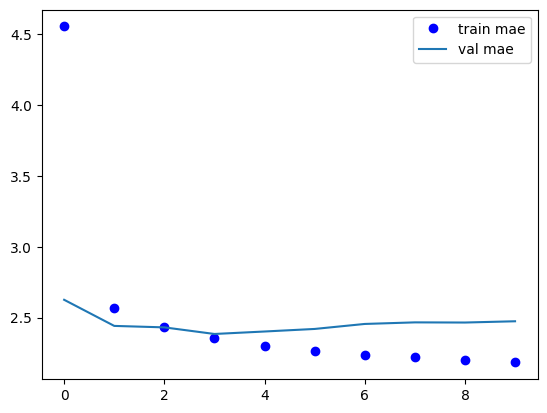

In [ ]:
plt.plot(hist.history['mae'],'bo',label='train mae')
plt.plot(hist.history['val_mae'],label='val mae')
plt.legend()
plt.show()

RNN 구현하기
  - 순환신경망
  - 가중치 공유

In [ ]:
from tensorflow.python.ops.logging_ops import timestamp
timesteps = 100  # 입력시퀀스의 길이
input_features = 32
output_features = 64
inputs = np.random.random( (timesteps,input_features) )
status_t = np.zeros((output_features,))
print(inputs.shape, status_t.shape)
W = np.random.random( (output_features,input_features) )
U = np.random.random( (output_features,output_features) )
b = np.random.random( (output_features,) )
successive_outputs = []  # 출력의 결과를 저장 리스트
for input_t in inputs:
  output_t = np.tanh(np.dot(W,input_t) + np.dot(U,status_t) + b )
  successive_outputs.append(output_t)
  status_t = output_t

(100, 32) (64,)


In [ ]:
final_output_sequence =  np.stack(successive_outputs,axis=0)
final_output_sequence

array([[1.        , 1.        , 1.        , ..., 0.99999999, 1.        ,
        0.99999994],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

순환신경망 RNN
  - 어떤 길이의 시퀀스도 처리할수 있으는 RNN


In [ ]:
num_feature = 14
inputs = tf.keras.Input(shape=(None,num_feature))
output = tf.keras.layers.SimpleRNN(16)(inputs)
output.shape

TensorShape([None, 16])

마지막 출력 스텝만 반환하는 RNN

In [ ]:
num_feature = 14
step = 120
inputs = tf.keras.Input(shape=(step,num_feature))
output = tf.keras.layers.SimpleRNN(16,return_sequences=False)(inputs)
output.shape

TensorShape([None, 16])

전체출력을 반환하는 RNN

In [ ]:
num_feature = 14
step = 120
inputs = tf.keras.Input(shape=(step,num_feature))
output = tf.keras.layers.SimpleRNN(16,return_sequences=True)(inputs)
output.shape

TensorShape([None, 120, 16])

스태킹(stacking)층

In [ ]:
num_feature = 14
step = 120
inputs = tf.keras.Input(shape=(step,num_feature))
x = tf.keras.layers.SimpleRNN(16,return_sequences=True)(inputs)
x = tf.keras.layers.SimpleRNN(16,return_sequences=True)(x)
output = tf.keras.layers.SimpleRNN(16)(x)
output.shape

TensorShape([None, 16])

LSTM에 순환 드랍아웃 적용하기

In [12]:
inputs = tf.keras.Input(shape=(sequence_length,raw_data.shape[-1]))  # 120,14
x = tf.keras.layers.LSTM(32,recurrent_dropout=0.25)(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs,outputs)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model_lstm_dropout.h5',save_best_only=True)
]
model.compile(loss = 'mse', metrics=['mae'])
hist = model.fit(train_dataset,epochs=50,validation_data=val_dataset,callbacks=callbacks)
print(f'test mae: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/50
819/819 [==============================] - 19s 14ms/step - loss: 112.3081 - mae: 8.5698 - val_loss: 66.5929 - val_mae: 6.5831
Epoch 2/50
819/819 [==============================] - 11s 13ms/step - loss: 70.8105 - mae: 6.6795 - val_loss: 51.2426 - val_mae: 5.7257
Epoch 3/50
819/819 [==============================] - 11s 13ms/step - loss: 63.9997 - mae: 6.2874 - val_loss: 44.9317 - val_mae: 5.2596
Epoch 4/50
819/819 [==============================] - 11s 14ms/step - loss: 59.5773 - mae: 6.0271 - val_loss: 40.9546 - val_mae: 5.0068
Epoch 5/50
819/819 [==============================] - 11s 14ms/step - loss: 56.8009 - mae: 5.8788 - val_loss: 36.8151 - val_mae: 4.6383
Epoch 6/50
819/819 [==============================] - 11s 13ms/step - loss: 55.3150 - mae: 5.7934 - val_loss: 34.6516 - val_mae: 4.4939
Epoch 7/50
819/819 [==============================] - 11s 13ms/step - loss: 54.1226 - mae: 5.7285 - val_loss: 36.2723 - val_mae: 4.7223
Epoch 8/50
819/819 [===========================

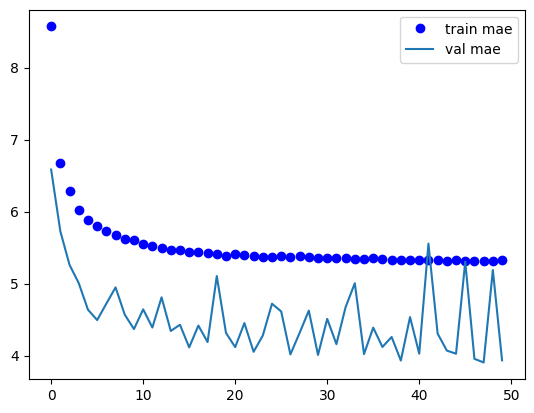

In [14]:
import matplotlib.pyplot as plt
plt.plot(hist.history['mae'],'bo',label='train mae')
plt.plot(hist.history['val_mae'],label='val mae')
plt.legend()
plt.show()

In [ ]:
# 드랍아웃 규제, 스태킹이 적용된 GRU 모델
inputs = tf.keras.Input(shape=(sequence_length,raw_data.shape[-1]))  # 120,14
x = tf.keras.layers.GRU(32,recurrent_dropout=0.5,return_sequences=True)(input)
x = tf.keras.layers.GRU(32,recurrent_dropout=0.5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs,outputs)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model_grud_dropout.h5',save_best_only=True)
]
model.compile(loss = 'mse', metrics=['mae'])
hist = model.fit(train_dataset,epochs=50,validation_data=val_dataset,callbacks=callbacks)
print(f'test mae: {model.evaluate(test_dataset)[1]:.2f}')